# TP3 - Market Basket Analysis 
INF8111 - Fouille de données, Fall 2019
### Team Components
    - Boisvenue, Étienne (1798942)
    - Le Page, Pierre-Étienne (1689985)
    - Wong, Jade (1738089)

**Authors**: Rodrigo Randel

## Date et directives de remise
Vous remettrez ce fichier nommé TP2\_NomDuMembre1\_NomDuMembre2\_NomDuMembre3.ipynb dans la boîte de remise sur moodle. 

Tout devra être remis avant le **3 decembre à 23h55**.

## Market Basket Analysis

Market Basket Analysis (MBA) is a data mining analytics technique to uncover associations between products or product grouping. By exploring interesting patterns from an extensive collection of data, MBA aims to understand/reveal customer purchase behaviors based upon the theory that if you purchased a certain set of products, then you are more (or less) likely to buy another group of products. In other words, MBA allows retailers to identify the relationship between the items that customers buy, revealing patterns of items often purchased together.

A widely approach to explore these patterns is by constructing ***association rules*** such as:
- **if** bought *ITEM_1* **then** will buy *ITEM_2* with **confidence** *X*.

These associations do not have to be 1-to-1 rules. They can involve many items. For example, a person in a supermarket may add eggs to his/her cart, then an MBA application may suggest that the person will also buy some bread and/or flour: 
    
+ **if** bought *EGGS* **then** will buy [*BREAD* with confidence *0.2*; *FLOUR* with confidence 0.05].

However, if the person now decides to add flour to his/her cart, the new association rule could be as showing below, suggesting ingredients to make a cake.

+ **if** bought [*EGGS, FLOUR*] **then** will buy [*SUGGAR* with confidence 0.45; BAKING POWDER with confidence 0.12; *BREAD* with confidence *0.03*].


There are many real scenarios where MBA plays a central role in data analysis, such as supermarket transactions, online orders or credit card history. Marketers may use these association rules to allocate correlated products close to each other on store shelves or make online suggestions so that customers buy more items. Some questions that an MBA can usually help retailers to answer are:

    - What items are often purchased together?
    - Given a basket, what items should be suggested?
    - How should items be placed together on the shelves?


### Objective

Your goal in this TP is to develop an MBA algorithm for revealing patterns by creating association rules in a big dataset with more than three millions supermarket transactions. However, mining association rules for large datasets is a very computationally intensive problem, which makes it almost impractical to perform it without a distributed system. Hence, to run your algorithm, you will have access to a distributed cloud computing cluster with hundreds of cores. 

To this end, a **MapReduce** algorithm will be implemented upon the [Apache Spark](http://spark.apache.org) framework, a fast cluster computing system. In a nutshell, Spark is an open source framework designed with a *scale-out* methodology which makes it a very powerful tool for programmers or application developers to perform a massive volume of computations and data processing in distributed environments. Sparks provides high-level APIs that make it easy to build parallel apps without needing to worry about how your code and data are parallelized/distributed thought the computing cluster. Spark does it all for you.
 
The implementation will follow the Market Basket Analysis algorithm presented by Jongwook Woo and Yuhang Xu (2012). The image **workflow.svg** Illustrates the algorithm's workflow, and is to be used for consultation throughout this TP. The blue boxes are the ones where you must implement a method to perform a map or reduce function, and the grey boxes represent their expected output. **All these operations are explained in details in the following sections.** 

<!---
# ![scale=0.5](workflow.svg "Algorithm Workflow")
-->

## 1. Setting up Spark

Spark runs on both Windows and UNIX-like systems (e.g., Linux, Mac OS). It's easy to run locally on one machine — all you need is to have Java installed on your system PATH, or the JAVA_HOME environment variable pointing to a Java installation. It is recommended that you have the **JDK v8** installed in your system. If you haven't, go to [Java's web page](https://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html) to download and install a Java Virtual Machine. Remember to set the environment variable JAVA_HOME if your installation does not do it automatically for you. 

The interface between Python and Spark is done through **PySpark**, which can be obtained following the sequence below:

1. First, go to http://spark.apache.org/downloads 
2. Select the newest Spark release and the Pre-built for Apache Hadoop 2.7 package 
3. Click for download **spark-2.4.4-bin-hadoop2.7.tgz** and unzip it in any folder of your preference. 
4. Next, export the following variables to link PYSPARK (Spark's python interface) to your python distribution in yout `~/.bash_profile` file.
```
    - export SPARK_HOME=/path/to/spark-2.4.4-bin-hadoop2.7
    - export PYTHONPATH="$SPARK_HOME/python:$SPARK_HOME/python/lib/py4j-0.10.7-src.zip:$SPARK_HOME/python/lib/pyspark.zip:$PYTHONPATH"
    - export PYSPARK_PYTHON=/path/to/your/python3
```
5. Run `source ~./bash_profile` to effictate the changes and reinitializate this jupyter notebook session.

### 1.1 Product Counting Example 

To test your installation and start to get familiarized with Spark, we will follow an example that counts how many times the products of a toy dataset were purchased.

The main entry point to start programming with Spark is the [RDD API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD), an excellent Spark abstraction to work with the MapReduce framework.  RDD is a collection of elements partitioned across the nodes of the cluster that can operate in parallel. In other words, RDD is how Spark keeps your data ready to perform some function (e.g., a map or reduce function) in parallel. **Do not worry if this still sounds confusing, it will be clear once you start implementing**. However, it is part of this TP to study/consult the [Spark python API](https://spark.apache.org/docs/latest/api/python/) and learn how to use it. Some useful functions that the RDD API offers are:

1. **map**: return a new RDD by applying a function to each element of this RDD.
2. **flatMap**: return a new RDD by first applying a function to all elements of this RDD, and then flattening the results. **Should be used when each entry will yield more than one mapped element**
3. **reduce**: reduces the elements of this RDD using the specified commutative and associative binary operator.
4. **reduceByKey**: merge the values for each key using an associative and commutative reduce function
5. **groupByKey**: group the values for each key in the RDD into a single sequence
6. **collect**: return a list that contains all of the elements in this RDD. **Should not be used when working with a lot of data**
7. **sample**: return a sampled subset of this RDD
8. **count**: return the number of elements in this RDD.
9. **filter**: return a new RDD containing only the elements that satisfy a predicate.

In [0]:
root_path = None
instacart_dir_path = None

In [2]:
#For use in Google Colab
import os

import sys
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install findspark
!pip install pyspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/'

root_path = sys.modules['__main__'].root_path
instacart_dir_path = root_path + 'instacart/'

--2019-12-03 02:33:04--  https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
Resolving www-us.apache.org (www-us.apache.org)... 40.79.78.1
Connecting to www-us.apache.org (www-us.apache.org)|40.79.78.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 230091034 (219M) [application/x-gzip]
Saving to: ‘spark-2.4.4-bin-hadoop2.7.tgz.1’

spark-2.4.4-bin-had 100%[===================>] 219.43M  30.8MB/s    in 8.2s    

2019-12-03 02:33:13 (26.8 MB/s) - ‘spark-2.4.4-bin-hadoop2.7.tgz.1’ saved [230091034/230091034]

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.

In [0]:
'''
# For use in Jupyter Notebook
# The required procedure for pyspark import
# Example taken from : 
# https://medium.com/@naomi.fridman/install-pyspark-to-run-on-jupyter-notebook-on-windows-4ec2009de21f
import findspark
findspark.init()
findspark.find()

import pyspark
findspark.find()

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

conf = pyspark.SparkConf().setAppName('appName').setMaster('local')

# Modified config to prevent timeouts
conf.set("spark.executor.heartbeatInterval","2400s")
conf.set("spark.network.timeout", "9000s")
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)
'''

In [0]:
#For use on google cloud platform
root_path = 'gs://tp3_inf8111_bucket/'
instacart_dir_path = root_path + 'instacart/'

In [3]:
import pyspark
from pyspark.sql import SparkSession

def map_to_product(row):
    """
    Map each transaction into a set of KEY-VALUE elements.
    The KEY is the word (product) itself and the VALUE is its number of apparitions.
    """
    products = row.transaction.split(';') # split products from the column transaction
    for p in products:
        yield (p, 1)

def reduce_product_by_key(value1, value2):
    "Reduce the mapped objects to unique words by merging (summing ) their values"
    return value1+value2

if instacart_dir_path is None:
  instacart_dir_path = 'instacart/'

if root_path is None:
  root_path = ''

# Initializates a object of SparkSession class, main entry point to Spark's funcionalites
spark = SparkSession.builder.getOrCreate()

# Read a toy dataset
toy = spark.read.csv(root_path + 'toy.csv', header=True)
print("Toy dataset")
toy.show()

# Obtain a RDD object to call a map function
toy_rdd = toy.rdd
print("Toy dataframe as a RDD object (list of Row objects):\n\t", toy_rdd.collect())

# Map function to identify all products
toy_rdd = toy_rdd.flatMap(map_to_product)
print("\nMapped products:\n\t", toy_rdd.collect())

# Reduce function to merge values of elements that share the same KEY
toy_rdd = toy_rdd.reduceByKey(reduce_product_by_key)
print("\nReduced (merged) products:\n\t", toy_rdd.collect())

print("\nVisualizing as a dataframe:")
toy_rdd.toDF(["product", "count_product"]).show()

Toy dataset
+--------+-----------+
|order_id|transaction|
+--------+-----------+
|       1|      a;b;c|
|       2|      a;b;d|
|       3|        b;c|
|       4|        b;c|
+--------+-----------+

Toy dataframe as a RDD object (list of Row objects):
	 [Row(order_id='1', transaction='a;b;c'), Row(order_id='2', transaction='a;b;d'), Row(order_id='3', transaction='b;c'), Row(order_id='4', transaction='b;c')]

Mapped products:
	 [('a', 1), ('b', 1), ('c', 1), ('a', 1), ('b', 1), ('d', 1), ('b', 1), ('c', 1), ('b', 1), ('c', 1)]

Reduced (merged) products:
	 [('a', 2), ('b', 4), ('c', 3), ('d', 1)]

Visualizing as a dataframe:
+-------+-------------+
|product|count_product|
+-------+-------------+
|      a|            2|
|      b|            4|
|      c|            3|
|      d|            1|
+-------+-------------+



### 1.2 Working the Spark's Dataframe

In the example above, we briefly used a Spark's Dataframe class, but only to obtain an RDD object with ```toy.rdd``` and to print the data as a structured table with the ```show()``` function. However, [Dataframe](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#) is a big part of the current Spark release and is built upon the RDD API. It is a distributed collection of rows under named columns, the same as a table in a relational database. Spark's Dataframe works similarily as [Pandas'](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). In fact, we can export (obtain) a Spark's data frame to (from) a pandas' data frame with the function ```toPandas()``` (```spark.createDataFrame```).

A central functionality of the data frame is to profit from the [Spark SQL](https://spark.apache.org/docs/latest/sql-programming-guide.html#sql), a module that allows SQL queries over structured data. For example, the same 'product counting example' could have been implemented as a sequence of SQL operations over the data:  

In [0]:
import pyspark.sql.functions as f

# Creates a new column, products, with all products appering in each transaction
print('New column \'products\': exploding the transaction\'s products to a new row')
df_toy = toy.withColumn('products', f.explode(f.split(toy.transaction, ';')))
df_toy.show()

# Performs a select query and group rows by the product name, aggreagating by counting
print('Couting unique products:')
df_toy.select(df_toy.products)\
      .groupBy(df_toy.products)\
      .agg(f.count('products').alias('count_product'))\
      .sort('count_product', ascending=False)\
      .show()

New column 'products': exploding the transaction's products to a new row
+--------+-----------+--------+
|order_id|transaction|products|
+--------+-----------+--------+
|       1|      a;b;c|       a|
|       1|      a;b;c|       b|
|       1|      a;b;c|       c|
|       2|      a;b;d|       a|
|       2|      a;b;d|       b|
|       2|      a;b;d|       d|
|       3|        b;c|       b|
|       3|        b;c|       c|
|       4|        b;c|       b|
|       4|        b;c|       c|
+--------+-----------+--------+

Couting unique products:
+--------+-------------+
|products|count_product|
+--------+-------------+
|       b|            4|
|       c|            3|
|       a|            2|
|       d|            1|
+--------+-------------+



Also, the same SQL operations performed above could have been done with a traditional SQL language query as showing below:

In [0]:
# Creates a relational table TOY in the Spark session
df_toy.createOrReplaceTempView("TOY")

spark.sql("SELECT t.products, COUNT(t.products) AS product_count"
          " FROM TOY t"
          " GROUP BY t.products"
          " ORDER BY product_count DESC").show()

+--------+-------------+
|products|product_count|
+--------+-------------+
|       b|            4|
|       c|            3|
|       a|            2|
|       d|            1|
+--------+-------------+



These SQL concepts are being mentioned here because they will be useful to us during the TP, mainly in Section 3, to manipulate the supermarket data, which is structured in data frames. Then, if you are not familiar with SQL, it is recommended that you follow a [tutorial](https://www.w3schools.com/sql/) to understand the basics.

## 2. MBA Algorithm 
 The following sections explain how you should develop each step of the MapReduce algorithm for our supermarket application. Figure workflow.png illustrates each step of the algorithm.
 
### 2.1 Map to Patterns (10 points)
For a given a set of transactions (i.e., the rows of our toy dataset), each transaction must be **mapped** into a set of *purchase patterns* found within the transaction. Formally, these patterns are subsets of products that represent a group of items bought together. 
    
For the MapReduce framework, each pattern must be created as a *KEY-VALUE* element, where they KEY can take the form of a singleton, a pair or a trio of products that are present in the transaction. More precisely, for each transaction, the mapping function must generate all possible **unique** subsets of size **ONE, TWO or THREE**.  The VALUE associated with each KEY is the number of times that the KEY appeared in the transaction (if we assume that no product appears more than once in the transaction, this value is always equal to one). 

Now, implement the  **map_to_patterns** function that receives a transaction (a row from the data frame) and returns the patterns found in the transaction. The mapped elements are a tuple (KEY, VALUE), where KEY is also a tuple of product names. It is crucial to notice that, since each entry (transaction) of the map function will **yield** more than one KEY-VALUE element, a *flatMap* must be invoked for this step.

For the toy dataset, the expected output is similar to:

<pre style="align:center; border:1px solid black;font-size: 10pt; line-height: 1.1; height: auto; width: 18em; padding-left:5px">
<code>
+---------------+-----------+
|       patterns|occurrences|
+---------------+-----------+
|         ('a',)|          1|
|     ('a', 'b')|          1|
|('a', 'b', 'c')|          1|
|     ('a', 'c')|          1|
|         ('b',)|          1|
|     ('b', 'c')|          1|
|         ('c',)|          1|
|         ('a',)|          1|
|     ('a', 'b')|          1|
|('a', 'b', 'd')|          1|
|     ('a', 'd')|          1|
|         ('b',)|          1|
|     ('b', 'd')|          1|
|         ('d',)|          1|
|         ('b',)|          1|
|     ('b', 'c')|          1|
|         ('c',)|          1|
|         ('b',)|          1|
|     ('b', 'c')|          1|
|         ('c',)|          1|
+---------------+-----------+
</code>
</pre>

In [4]:
%%time

from pyspark.sql import SparkSession
import pyspark.sql.functions as f

def format_tuples(pattern):
    """
    Used for visualizition.
    Transforms tuples to a string since Dataframe does not support column of tuples with different sizes
    (a,b,c) -> '(a,b,c)'
    """
    return (str(pattern[0]), str(pattern[1]))

def map_to_patterns(row):
    
    products = row.transaction.split(';') # split products from the column transaction
    products.sort()
    
    if products is not None:
        for i in range(len(products)):
            
            if not products[i]:
                continue
                
            yield ((products[i],), 1)
            
            for j in range(len(products)):
                if i >= j:
                    continue

                yield ((products[i], products[j]), 1)
                
                for k in range(len(products)):
                    if j >= k:
                        continue
                    
                    yield((products[i], products[j], products[k]), 1) 

toy_rdd = toy.rdd
patterns_rdd = toy_rdd.flatMap(map_to_patterns)
# Output as dataframe
patterns_rdd.map(format_tuples).toDF(['patterns', 'occurrences']).show()

+---------------+-----------+
|       patterns|occurrences|
+---------------+-----------+
|         ('a',)|          1|
|     ('a', 'b')|          1|
|('a', 'b', 'c')|          1|
|     ('a', 'c')|          1|
|         ('b',)|          1|
|     ('b', 'c')|          1|
|         ('c',)|          1|
|         ('a',)|          1|
|     ('a', 'b')|          1|
|('a', 'b', 'd')|          1|
|     ('a', 'd')|          1|
|         ('b',)|          1|
|     ('b', 'd')|          1|
|         ('d',)|          1|
|         ('b',)|          1|
|     ('b', 'c')|          1|
|         ('c',)|          1|
|         ('b',)|          1|
|     ('b', 'c')|          1|
|         ('c',)|          1|
+---------------+-----------+

CPU times: user 21.9 ms, sys: 6.53 ms, total: 28.5 ms
Wall time: 247 ms


### 2.2 Reduce patterns (2.5 points)
Once different CPUs processed the transactions, a **reduce** function must take place to combine identical KEYS (the subset of products) and compute the total number of its occurrences in the entire dataset. In other words, this reduce procedure must sum the *VALUE* of each identical KEY.

Create a **reduce_patterns** function below that must sum the VALUE of each pattern.
For the toy dataset, the expected output is:
<pre style="align:center; border:1px solid black;font-size: 10pt; line-height: 1.1; height: auto; width: 24em; padding-left:5px">
<code>
+---------------+--------------------+
|       patterns|combined_occurrences|
+---------------+--------------------+
|         ('a',)|                   2|
|     ('a', 'b')|                   2|
|('a', 'b', 'c')|                   1|
|     ('a', 'c')|                   1|
|         ('b',)|                   4|
|     ('b', 'c')|                   3|
|         ('c',)|                   3|
|('a', 'b', 'd')|                   1|
|     ('a', 'd')|                   1|
|     ('b', 'd')|                   1|
|         ('d',)|                   1|
+---------------+--------------------+
</code>
</pre>


In [5]:
def reduce_pattern_by_key(value1, value2):
    return value1 + value2

combined_patterns_rdd = patterns_rdd.reduceByKey(reduce_pattern_by_key)

# Output as dataframe
combined_patterns_rdd.map(format_tuples).toDF(['patterns', 'combined_occurrences']).show()

+---------------+--------------------+
|       patterns|combined_occurrences|
+---------------+--------------------+
|         ('a',)|                   2|
|     ('a', 'b')|                   2|
|('a', 'b', 'c')|                   1|
|     ('a', 'c')|                   1|
|         ('b',)|                   4|
|     ('b', 'c')|                   3|
|         ('c',)|                   3|
|('a', 'b', 'd')|                   1|
|     ('a', 'd')|                   1|
|     ('b', 'd')|                   1|
|         ('d',)|                   1|
+---------------+--------------------+



### 2.3 Map to subpatterns (15 points)
Next, another **map** function should be applied to generate subpatterns. Once again, the subpatterns are KEY-VALUE elements, where the KEY is a subset of products as well. However, creating the subpattern's KEY is a different procedure. This time, the idea is to break down the list of products of each pattern (pattern KEY), remove one product at a time, and yield the resulting list as the new subpattern KEY. 

For example, for a given pattern $P$ with three products, $p_1, p_2 $ and $p_3$, three new subpatterns KEYs are going to be created: (i) remove $p_1$ and yield ($p_2, p_3$); (ii) remove $p_2$ and yield ($p_1,p_3$); and (iii) remove $p_3$ and yield ($p_1,p_2$). 

Additionally, the subpattern's VALUE structure will also be different. Instead of just single integer value as we had in the patterns, this time a *tuple* should be created for the subpattern VALUE. This tuple contains the product that was removed when yielding the KEY and the number of times the pattern appeared. For the example above, the values should be ($p_1,v$), ($p_2,v$) and ($p_3,v$), respectively, where $v$ is the VALUE of the pattern. 

The idea behind subpatterns is to create **rules** such as: when the products of KEY were bought, the item present in the VALUE was also bought *v* times. Furthermore, each pattern should also yield a subpattern where the KEY is the same list of products of the pattern, but the VALUE is a tuple with a null product (None) and the number of times the pattern appeared. This element will be useful to keep track of how many times such a pattern was found and later will be used to compute the confidence value when generating the association rules. 

Now, implement the  **map_to_subpatterns** function that receives a pattern and yields all found subpatterns. Once again, each entry (pattern) will generate more than one KEY-VALUE element, then a flatMap function must be called.

For the toy dataset, the expected output is:

<pre style="align:center; border:1px solid black;font-size: 10pt; line-height: 1.1; height: auto; width: 17em; padding-left:5px">
<code>
+---------------+---------+
|    subpatterns|    rules|
+---------------+---------+
|         ('a',)|(None, 2)|
|     ('a', 'b')|(None, 2)|
|         ('b',)| ('a', 2)|
|         ('a',)| ('b', 2)|
|('a', 'b', 'c')|(None, 1)|
|     ('b', 'c')| ('a', 1)|
|     ('a', 'c')| ('b', 1)|
|     ('a', 'b')| ('c', 1)|
|     ('a', 'c')|(None, 1)|
|         ('c',)| ('a', 1)|
|         ('a',)| ('c', 1)|
|         ('b',)|(None, 4)|
|     ('b', 'c')|(None, 3)|
|         ('c',)| ('b', 3)|
|         ('b',)| ('c', 3)|
|         ('c',)|(None, 3)|
|('a', 'b', 'd')|(None, 1)|
|     ('b', 'd')| ('a', 1)|
|     ('a', 'd')| ('b', 1)|
|     ('a', 'b')| ('d', 1)|
|     ('a', 'd')|(None, 1)|
|         ('d',)| ('a', 1)|
|         ('a',)| ('d', 1)|
|     ('b', 'd')|(None, 1)|
|         ('d',)| ('b', 1)|
|         ('b',)| ('d', 1)|
|         ('d',)|(None, 1)|
+---------------+---------+
</code>
</pre>

In [6]:
from copy import deepcopy

def map_to_subpatterns(pattern):
    
    lst_transactions = pattern[0]
    pattern_count = pattern[1]
        
    yield ((tuple(lst_transactions), None), pattern_count)
    
    if len(lst_transactions) > 1:
        
        for transaction_to_remove in lst_transactions:

            resulting_transactions = list(deepcopy(lst_transactions))

            resulting_transactions.remove(transaction_to_remove)

            yield ((tuple(resulting_transactions), transaction_to_remove), pattern_count)
    

subpatterns_rdd = combined_patterns_rdd.flatMap(map_to_subpatterns).reduceByKey(lambda x,y: x + y).map(lambda x : (x[0][0], (x[0][1], x[1])))

# Output as dataframe
subpatterns_rdd.map(format_tuples).toDF(['subpatterns', 'rules']).show(100)

+---------------+---------+
|    subpatterns|    rules|
+---------------+---------+
|         ('a',)|(None, 2)|
|     ('a', 'b')|(None, 2)|
|         ('b',)| ('a', 2)|
|         ('a',)| ('b', 2)|
|('a', 'b', 'c')|(None, 1)|
|     ('b', 'c')| ('a', 1)|
|     ('a', 'c')| ('b', 1)|
|     ('a', 'b')| ('c', 1)|
|     ('a', 'c')|(None, 1)|
|         ('c',)| ('a', 1)|
|         ('a',)| ('c', 1)|
|         ('b',)|(None, 4)|
|     ('b', 'c')|(None, 3)|
|         ('c',)| ('b', 3)|
|         ('b',)| ('c', 3)|
|         ('c',)|(None, 3)|
|('a', 'b', 'd')|(None, 1)|
|     ('b', 'd')| ('a', 1)|
|     ('a', 'd')| ('b', 1)|
|     ('a', 'b')| ('d', 1)|
|     ('a', 'd')|(None, 1)|
|         ('d',)| ('a', 1)|
|         ('a',)| ('d', 1)|
|     ('b', 'd')|(None, 1)|
|         ('d',)| ('b', 1)|
|         ('b',)| ('d', 1)|
|         ('d',)|(None, 1)|
+---------------+---------+



### 2.4 Reduce Subpatterns (2.5 points)
Once again, a **reduce** function will be required to group all the subpatterns by their KEY. The objective of this reducing procedure is to create a list with all the **rules** that appeared by a KEY. Hence, the expected resulting of the reduce function is also a KEY-VALUE element, where the KEY is the subpattern's KEY, and the VALUE is a group containing all the VALUEs of the subpatterns that share the same KEY.

For the toy dataset, the expected output is:

<pre style="align:center; border:1px solid black;font-size: 10pt; line-height: 1.1; height: auto; width: 36em; padding-left:5px">
<code>
+---------------+-----------------------------------------+
|subpatterns    |combined_rules                           |
+---------------+-----------------------------------------+
|('a',)         |[(None, 2), ('b', 2), ('c', 1), ('d', 1)]|
|('a', 'b')     |[(None, 2), ('c', 1), ('d', 1)]          |
|('b',)         |[('a', 2), (None, 4), ('c', 3), ('d', 1)]|
|('a', 'b', 'c')|[(None, 1)]                              |
|('b', 'c')     |[('a', 1), (None, 3)]                    |
|('a', 'c')     |[('b', 1), (None, 1)]                    |
|('c',)         |[('a', 1), ('b', 3), (None, 3)]          |
|('a', 'b', 'd')|[(None, 1)]                              |
|('b', 'd')     |[('a', 1), (None, 1)]                    |
|('a', 'd')     |[('b', 1), (None, 1)]                    |
|('d',)         |[('a', 1), ('b', 1), (None, 1)]          |
+---------------+-----------------------------------------+
</code>
</pre>


In [7]:
combined_rules = subpatterns_rdd.map(lambda x: (x[0],[x[1]])).reduceByKey(lambda x , y: x + y)

# Output as dataframe
combined_rules.map(format_tuples).toDF(['subpatterns', 'combined_rules']).show(truncate=False)

+---------------+-----------------------------------------+
|subpatterns    |combined_rules                           |
+---------------+-----------------------------------------+
|('a',)         |[(None, 2), ('b', 2), ('c', 1), ('d', 1)]|
|('a', 'b')     |[(None, 2), ('c', 1), ('d', 1)]          |
|('b',)         |[('a', 2), (None, 4), ('c', 3), ('d', 1)]|
|('a', 'b', 'c')|[(None, 1)]                              |
|('b', 'c')     |[('a', 1), (None, 3)]                    |
|('a', 'c')     |[('b', 1), (None, 1)]                    |
|('c',)         |[('a', 1), ('b', 3), (None, 3)]          |
|('a', 'b', 'd')|[(None, 1)]                              |
|('b', 'd')     |[('a', 1), (None, 1)]                    |
|('a', 'd')     |[('b', 1), (None, 1)]                    |
|('d',)         |[('a', 1), ('b', 1), (None, 1)]          |
+---------------+-----------------------------------------+



## 2.5. Map to Association Rules (15 points)
Finally, the last step of the algorithm is to create the association rules to perform the market basket analysis. The goal of this map function is to calculate the **confidence** level of buying a product, knowing that there is already a set of products in the basket. Thus, the KEY of the subpattern is the set of products placed in the basket and, for each product present in the list of rules, i.e., in the VALUE, the confidence can be calculated as:

\begin{align*}
\frac{\text{number of times the product was bought together with KEY }}{\text{number of times the KEY appeared}}
\end{align*}

For the example given in the Figure workflow, *coffee* was bought 20 times and, in 17 of them, *milk* was bought together. Then, the confidence level of buying *milk* knowing that *coffee* is in the basket is $\frac{17}{20} = 0.85$, which means that in 85% of the times the coffee was bought, milk was purchased as well.

Implement the **map_to_assoc_rules** function that calculates the confidence level for each subpattern.

For the toy dataset, the expected output is:
<pre style="align:center; border:1px solid black;font-size: 9pt; line-height: 1.1; height: auto; width: 35em; padding-left:5px">
<code>
+---------------+---------------------------------------+
|patterns       |association_rules                      |
+---------------+---------------------------------------+
|('a',)         |[('b', 1.0), ('c', 0.5), ('d', 0.5)]   |
|('a', 'b')     |[('c', 0.5), ('d', 0.5)]               |
|('b',)         |[('a', 0.5), ('c', 0.75), ('d', 0.25)] |
|('a', 'b', 'c')|[]                                     |
|('b', 'c')     |[('a', 0.3333333333333333)]            |
|('a', 'c')     |[('b', 1.0)]                           |
|('c',)         |[('a', 0.3333333333333333), ('b', 1.0)]|
|('a', 'b', 'd')|[]                                     |
|('b', 'd')     |[('a', 1.0)]                           |
|('a', 'd')     |[('b', 1.0)]                           |
|('d',)         |[('a', 1.0), ('b', 1.0)]               |
+---------------+---------------------------------------+
</code>
</pre>

In [8]:
def map_to_assoc_rules(rule):
    pattern = rule[0]
    combined_rules = rule[1]
    
    nb_times_key_appeared = -1
    
    other_occurences = []
    
    for occurence in combined_rules:
        if occurence[0] is None:
            nb_times_key_appeared = occurence[1]
        else:
            other_occurences.append(occurence)

    if len(other_occurences) == 0:
        yield (rule[0], [])
    
    for occurence in other_occurences:
        yield (rule[0], [(occurence[0], round(float(occurence[1]) / float(nb_times_key_appeared), 2))])
    

assoc_rules = combined_rules.flatMap(map_to_assoc_rules).reduceByKey(lambda x , y: x + y)

# Output as dataframe
assoc_rules.map(format_tuples).toDF(['patterns', 'association_rules']).show(truncate=False)

+---------------+--------------------------------------+
|patterns       |association_rules                     |
+---------------+--------------------------------------+
|('a',)         |[('b', 1.0), ('c', 0.5), ('d', 0.5)]  |
|('a', 'b')     |[('c', 0.5), ('d', 0.5)]              |
|('b',)         |[('a', 0.5), ('c', 0.75), ('d', 0.25)]|
|('a', 'b', 'c')|[]                                    |
|('b', 'c')     |[('a', 0.33)]                         |
|('a', 'c')     |[('b', 1.0)]                          |
|('c',)         |[('a', 0.33), ('b', 1.0)]             |
|('a', 'b', 'd')|[]                                    |
|('b', 'd')     |[('a', 1.0)]                          |
|('a', 'd')     |[('b', 1.0)]                          |
|('d',)         |[('a', 1.0), ('b', 1.0)]              |
+---------------+--------------------------------------+



## 3. Instacart dataset

With your MBA algorithm ready to be used, now it is time to work on the real dataset. For this part of the TP, download the [instacart](https://www.instacart.com/datasets/grocery-shopping-2017) dataset and read its [description](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b) to understand how the dataset is structured. 

Before applying the developed algorithm on the instacart dataset, you must first filter the transactions to be in the same format defined by your algorithm (one transaction per row). To manipulate the data, we can use Spark's data frame and the SQL module presented in Section 1.

The following code cell uses the Spark SQL module to read the orders from the ``order_products__train.csv`` and the detailed information from ``orders.csv`` and ``products.csv`` to construct a data frame that contains a list of all products ever purchased by each user.

In [0]:
df_order_prod = spark.read.csv(instacart_dir_path + 'order_products__train.csv', header=True, sep=',', inferSchema=True)
print('order_products__train.csv')
df_order_prod.show(5)

df_orders = spark.read.csv(instacart_dir_path + 'orders.csv', header=True, sep=',', inferSchema=True)
print('orders.csv')
df_orders.show(5)

df_products = spark.read.csv(instacart_dir_path + 'products.csv', header=True, sep=',', inferSchema=True)
print('products.csv')
df_products.show(5)


"""
List of products ever purchased by each user
"""
# USING SQL
df_order_prod.createOrReplaceTempView("order_prod") # creates table 'order_prod'
df_orders.createOrReplaceTempView("orders") # creates table 'orders'
df_products.createOrReplaceTempView("products") # creates table 'products'
spark.sql('SELECT o.user_id, COLLECT_LIST(p.product_name) AS products' 
               ' FROM orders o '
               ' INNER JOIN order_prod op ON op.order_id = o.order_id'
               ' INNER JOIN products p    ON op.product_id = p.product_id'
               ' GROUP BY user_id ORDER BY o.user_id').show(5, truncate=80)


# USING DATAFRAME OPERATIONS
# df_orders.join(df_order_prod, df_order_prod.order_id == df_orders.order_id, 'inner')\
# .join(df_products, df_products.product_id == df_order_prod.product_id, 'inner')\
# .groupBy(df_orders.user_id).agg(f.collect_list(df_products.product_name).alias('products'))\
# .orderBy(df_orders.user_id).show(5, truncate=80)

order_products__train.csv
+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       1|     49302|                1|        1|
|       1|     11109|                2|        1|
|       1|     10246|                3|        0|
|       1|     49683|                4|        0|
|       1|     43633|                5|        1|
+--------+----------+-----------------+---------+
only showing top 5 rows

orders.csv
+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
| 2539329|      1|   prior|           1|        2|                8|                  null|
| 2398795|      1|   prior|           2|        3|                7|                  15.0|
|  473747|      1|   prior| 

### 3.1 Business Insights (25 points) 

Now, you are the data scientist. Considering only the orders from ``order_products__train.csv``, use of Spark SQL module, performing with SQL or data frame, to answer the following questions:

1. What are the top 10 products which have the highest probability of being reordered (consider only products purchased at least 40 times)? 
2. What are the busiest shopping hours for each department?
    - Hint: plot a figure containing a time series for each department 
4. What is the size of the orders (basket size)? 
    - Hint: plot the basket size distribution 

In [0]:
df_order_prod.createOrReplaceTempView("order_prod") # creates table 'order_prod'
df_products.createOrReplaceTempView("products") # creates table 'order_prod'

#1. What are the top 10 products which have the highest probability of being reordered (consider only products purchased at least 40 times)?
spark.sql(' SELECT mostReorderdProducts.product_id, p.product_name, (mostReorderdProducts.reorderCount / mostReorderdProducts.orderCount) as prob_reorder '
          ' FROM '
              '( '
                  'SELECT o.product_id, CAST(SUM(o.reordered) as DECIMAL) as reorderCount, CAST(COUNT(1) as DECIMAL) as orderCount' 
                   ' FROM order_prod o'
                   ' INNER JOIN '
                      '('
                          ' SELECT product_id, COUNT(product_id) as prd_count '
                          ' FROM order_prod'
                          ' GROUP BY product_id'
                       ') as product_count '
                          ' ON product_count.prd_count >= 40 '
                            ' AND product_count.product_id = o.product_id'
                   ' GROUP BY o.product_id'
              ') as mostReorderdProducts '
          ' INNER JOIN products p ON mostReorderdProducts.product_id = p.product_id'
          ' ORDER BY prob_reorder DESC').show(10, truncate=80)

+----------+-------------------------------------+-------------+
|product_id|                         product_name| prob_reorder|
+----------+-------------------------------------+-------------+
|      1729|                 2% Lactose Free Milk|0.93478260870|
|     20940|                 Organic Low Fat Milk|0.91304347826|
|     12193|            100% Florida Orange Juice|0.89830508475|
|     31764|Original Sparkling Seltzer Water Cans|0.88888888889|
|     21038|              Organic Spelt Tortillas|0.88888888889|
|     24852|                               Banana|0.88417173983|
|       117|                   Petit Suisse Fruit|0.88333333333|
|     39180|               Organic Lowfat 1% Milk|0.88198757764|
|     12384|  Organic Lactose Free 1% Lowfat Milk|0.88104089219|
|     24024|                       1% Lowfat Milk|0.87852494577|
+----------+-------------------------------------+-------------+
only showing top 10 rows



In [0]:
df_departments = spark.read.csv(instacart_dir_path + 'departments.csv', header=True, sep=',', inferSchema=True)
print('products.csv')
df_departments.show(5)

products.csv
+-------------+----------+
|department_id|department|
+-------------+----------+
|            1|    frozen|
|            2|     other|
|            3|    bakery|
|            4|   produce|
|            5|   alcohol|
+-------------+----------+
only showing top 5 rows



In [0]:
df_orders.createOrReplaceTempView("orders") # creates table 'orders'
df_products.createOrReplaceTempView("products")
df_departments.createOrReplaceTempView("departments")

#2. What are the busiest shopping hours for each department?

print("Regardons d'abord la distribution des commandes au fil du temps.")

orders_df = spark.sql(
        'SELECT CAST(p.department_id as INT) as department_nb, d.department, o.order_hour_of_day, COUNT(o.order_hour_of_day) as order_count' 
        ' FROM order_prod op '
        ' INNER JOIN orders o ON op.order_id = o.order_id '
        ' INNER JOIN products p ON p.product_id = op.product_id'
        ' INNER JOIN departments d ON d.department_id = p.department_id'
        ' GROUP BY department_nb, d.department, o.order_hour_of_day'
        ' ORDER BY department, o.order_hour_of_day')

# Creates a list of row values for ordering, iteration and display in a plot.
order_values = orders_df.rdd.map(lambda row : ((row[0], row[1]), [(row[2], row[3])])).reduceByKey(lambda x, y : x + y).collect()

Regardons d'abord la distribution des commandes au fil du temps.


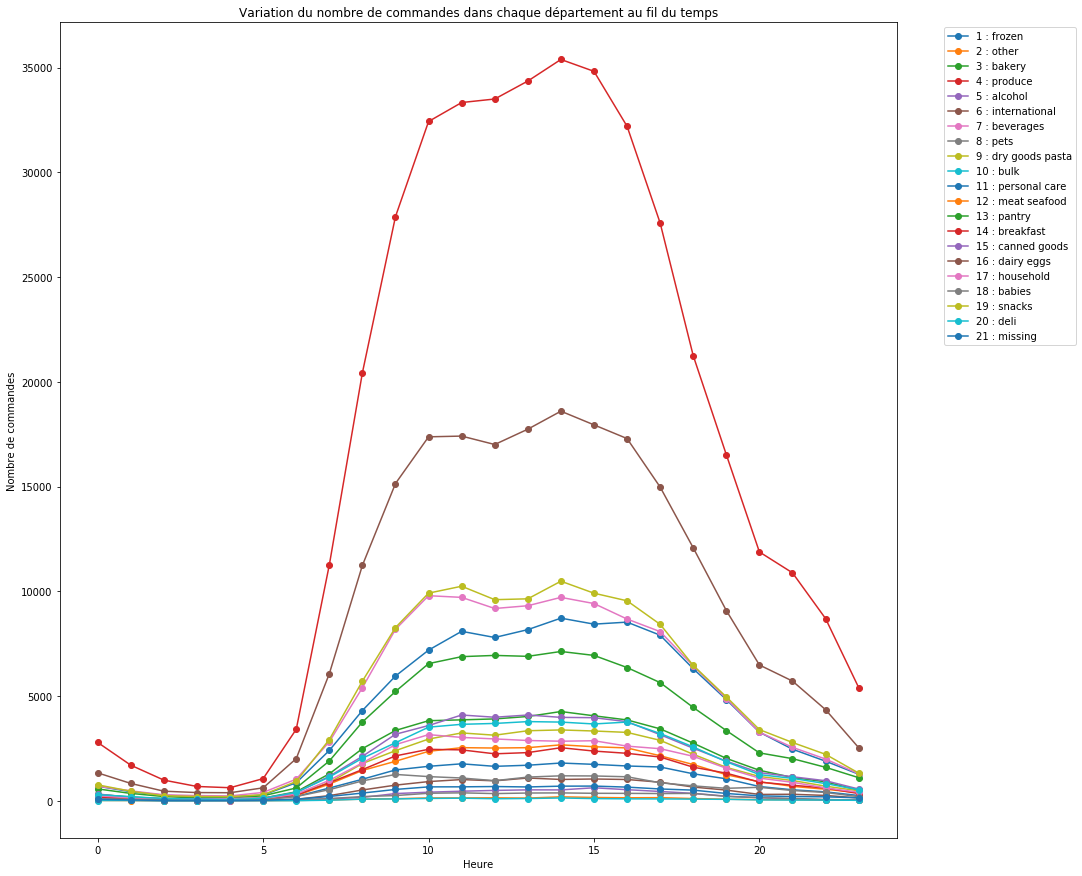

In [0]:
import matplotlib.pyplot as plt

# Order the rows using the department_ids for ordered display in the legend.
order_values.sort(key=lambda x: x[0][0])

plt.figure(figsize=(15,15))
plt.title("Variation du nombre de commandes dans chaque département au fil du temps")
plt.xlabel("Heure")
plt.ylabel("Nombre de commandes")

lines = []
line_labels = []

# Iterates through each row to generate the plot.
for department_orders in order_values:
    
    list_time = []
    list_order_count = []

    order_count_in_time = department_orders[1]
    for order_count_per_hour in order_count_in_time:
        hour = order_count_per_hour[0]
        list_time.append(hour)  
        list_order_count.append(order_count_per_hour[1])
    line, = plt.plot(list_time,list_order_count, '-o', label=str(department_orders[0][0]) + " : " + department_orders[0][1])
    lines.append(line)
    line_labels.append(str(department_orders[0][0]) + " : " + department_orders[0][1])

plt.legend(lines, line_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [0]:
spark.sql(
    'WITH departmentHours as '
    '('
        'SELECT p.department_id, d.department, o.order_hour_of_day, COUNT(o.order_hour_of_day) as hour_instance_count' 
        ' FROM order_prod op '
        ' INNER JOIN orders o ON op.order_id = o.order_id '
        ' INNER JOIN products p ON p.product_id = op.product_id'
        ' INNER JOIN departments d ON d.department_id = p.department_id'
        ' GROUP BY p.department_id, d.department, o.order_hour_of_day'
    ')'
    ' SELECT '
        ' CAST(maxCount.department_id as INT) as department_nb, '
        ' maxCount.department as department_name,'
        ' dh.order_hour_of_day as busiest_hour_of_day '
    ' FROM '
    '( '
        'SELECT department_id, department, MAX(hour_instance_count) as max_order_count '
        ' FROM departmentHours GROUP BY department_id, department'
    ') as maxCount '
    ' INNER JOIN departmentHours dh'
        ' ON dh.department_id = maxCount.department_id '
            ' AND dh.hour_instance_count = maxCount.max_order_count'
    ' ORDER BY department_nb').show()

+-------------+---------------+-------------------+
|department_nb|department_name|busiest_hour_of_day|
+-------------+---------------+-------------------+
|            1|         frozen|                 14|
|            2|          other|                 14|
|            3|         bakery|                 14|
|            4|        produce|                 14|
|            5|        alcohol|                 15|
|            6|  international|                 13|
|            7|      beverages|                 10|
|            8|           pets|                 11|
|            9|dry goods pasta|                 14|
|           10|           bulk|                 14|
|           11|  personal care|                 14|
|           12|   meat seafood|                 14|
|           13|         pantry|                 14|
|           14|      breakfast|                 14|
|           15|   canned goods|                 13|
|           15|   canned goods|                 11|
|           

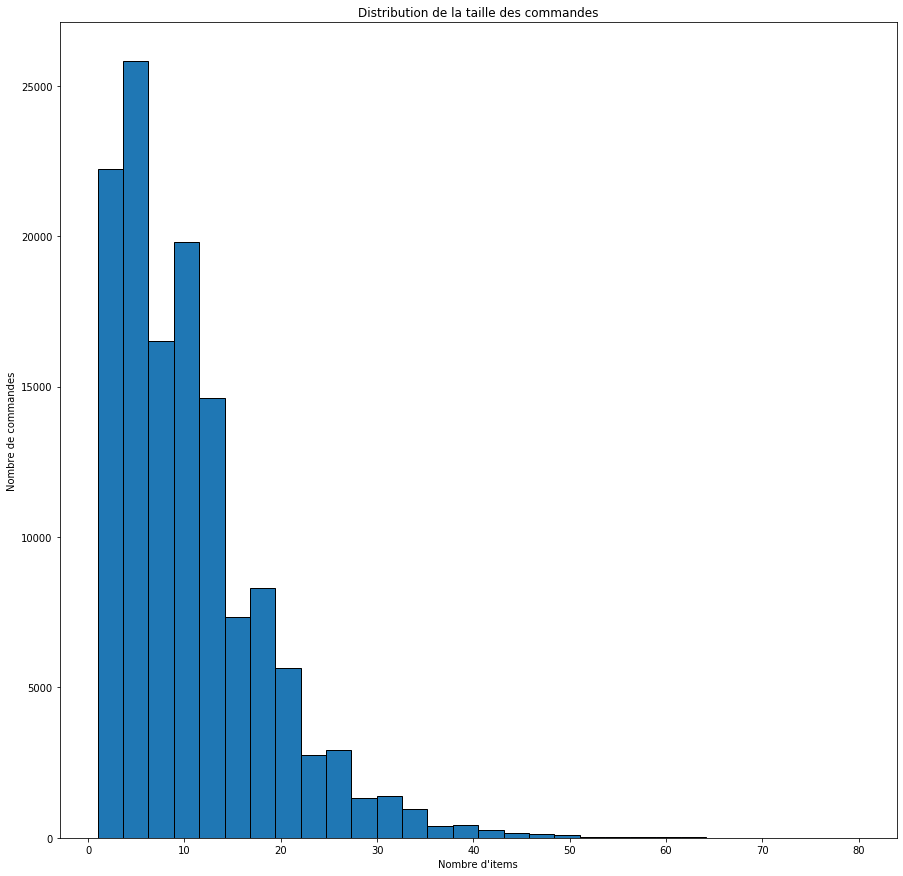

mean : 10.552759338155157
median : 9.0
+--------+-----------+
|order_id|basket_size|
+--------+-----------+
|    1342|          8|
|    1591|         31|
|    4519|          1|
|    4935|          1|
|    6357|          9|
|   10362|         36|
|   19204|         14|
|   29601|         17|
|   31035|          4|
|   40011|          6|
|   46266|         13|
|   51607|          6|
|   58797|          8|
|   61793|          6|
|   67089|         17|
|   70863|          5|
|   88674|          5|
|   91937|          5|
|   92317|         14|
|   99621|          8|
+--------+-----------+
only showing top 20 rows



In [0]:
import numpy as np
import matplotlib.pyplot as plt

df_order_prod.createOrReplaceTempView("order_prod") # creates table 'order_prod'

#3. What is the size of the orders (basket size)?
df_order_size = spark.sql('SELECT COUNT(1) as basket_size FROM order_prod GROUP BY order_id')

order_sizes = df_order_size.rdd.collect()

plt.figure(figsize=(15,15))
plt.title("Distribution de la taille des commandes")
plt.xlabel("Nombre d'items")
plt.ylabel("Nombre de commandes")

lines = []
line_labels = []

arr_order_size = np.array(order_sizes)

plt.hist(arr_order_size, edgecolor="black", bins=30)

plt.show()

print("mean : " + str(np.mean(arr_order_size)))
print("median : " + str(np.median(arr_order_size)))

df_basket_size = spark.sql('SELECT order_id, COUNT(1) as basket_size FROM order_prod GROUP BY order_id')

df_basket_size.show()

### 3.2 Run MBA for the training set (15 points)

Using the orders from the ``order_products__train.csv``, create a data frame where each row contain just one column, the transaction, with the list of purchased products. For this task, you do not have to query for the product names to run the MBA algorithm. You can assume that the product name is its id. This can accelerate the algorithm since the product names can be quite big.

You must report the time spent to perform this task.

In [0]:
%%time

df_order_prod.createOrReplaceTempView("order_prod") # creates table 'order_prod'

############# Comments for each row after the query : ###################
#     ' ORDER BY op.order_id').rdd.map(lambda r... - We generate a string composed of the product_ids split by a ";" to fit the map_to_pattenrs algorithm
# .toDF(['order_id', 'transaction']).rdd.flatMa... - We generate the baskets with a single a pair or a triple of product_ids from the list of product_ids for each order as patterns and we count their occurences in all the data. 
# .flatMap(map_to_subpatterns).reduceByKey(lamb... - We create association subpattenrs from the generated patterns
# .map(lambda x : (x[0][0], [(x[0][1], x[1])]))... - We put the subpatterns associations in a list to merge on a single row during the reduceByKey 
# .flatMap(map_to_assoc_rules).reduceByKey(lamb... - We calculate execute the MBA algorithm
# .map(format_tuples).toDF(['ordered_product', ... - We create the required dataframe and display the products and their association rules
spark.sql(
    'SELECT order_id, COLLECT_LIST(CAST(op.product_id as STRING)) as transaction ' 
    ' FROM order_prod op '  
    ' GROUP BY op.order_id '
    ' ORDER BY op.order_id').rdd.map(lambda row : (row[0], ";".join([str(prod_id) for prod_id in row[1]])))\
.toDF(['order_id', 'transaction']).rdd.flatMap(map_to_patterns).reduceByKey(lambda x , y: x + y)\
.flatMap(map_to_subpatterns).reduceByKey(lambda x,y: x + y)\
.map(lambda x : (x[0][0], [(x[0][1], x[1])])).reduceByKey(lambda x , y: x + y)\
.flatMap(map_to_assoc_rules).reduceByKey(lambda x , y: x + y)\
.map(format_tuples).toDF(['ordered_product', 'association_rules']).show(5, truncate=80)
    

+---------------+--------------------------------------------------------------------------------+
|ordered_product|                                                               association_rules|
+---------------+--------------------------------------------------------------------------------+
| [22848, 43961]|[[21574, 1.0], [20723, 1.0], [2750, 1.0], [49610, 1.0], [6300, 1.0], [5144, 1...|
| [33000, 44349]|[[11422, 0.5], [5876, 0.5], [40604, 0.5], [37067, 0.5], [30995, 0.5], [20434,...|
| [27344, 44156]|[[39032, 0.5], [5077, 0.5], [12899, 0.5], [26665, 0.5], [28157, 0.5], [40338,...|
|    [23165, 45]|[[19057, 0.1111111111111111], [2344, 0.1111111111111111], [27966, 0.222222222...|
| [11136, 33000]|[[36070, 0.3333333333333333], [46709, 0.3333333333333333], [42699, 0.33333333...|
+---------------+--------------------------------------------------------------------------------+
only showing top 5 rows

CPU times: user 1.18 s, sys: 273 ms, total: 1.45 s
Wall time: 4h 13min


**The code segments below where used to build the one above.This breakdown helps understand what tasks are the most computationnaly expensive in our treatment.**

In [0]:
%%time

product_order_count = df_products_per_order.rdd.flatMap(map_to_patterns).reduceByKey(lambda x , y: x + y)
product_order_count.map(format_tuples).toDF(['pattern', 'occurences']).show(5, truncate=80)

+---------------------------+----------+
|                    pattern|occurences|
+---------------------------+----------+
|         ('24489', '40706')|        86|
| ('13176', '18441', '3880')|         1|
|('15455', '15995', '20520')|         1|
|  ('15455', '18117', '329')|         1|
|('15455', '24964', '27966')|         1|
+---------------------------+----------+
only showing top 5 rows

CPU times: user 82.2 ms, sys: 21.2 ms, total: 103 ms
Wall time: 11min 3s


In [0]:
%%time

rdd_subpattern_rules = product_order_count.flatMap(map_to_subpatterns).reduceByKey(lambda x,y: x + y)
rdd_subpattern_rules.map(format_tuples).toDF(['sub_pattenrs', 'rules']).show(5, truncate=80)

+-----------------------------+-----+
|                 sub_pattenrs|rules|
+-----------------------------+-----+
|  (('24382', '4818'), '7123')|    1|
|(('16349', '26648'), '18027')|    1|
|(('13291', '48622'), '17795')|    1|
|(('33222', '35970'), '45541')|    1|
|(('12114', '27156'), '22993')|    1|
+-----------------------------+-----+
only showing top 5 rows

CPU times: user 300 ms, sys: 57 ms, total: 357 ms
Wall time: 1h 1min


In [0]:
%%time

rdd_subpattern_combined_rules = rdd_subpattern_rules.map(lambda x : (x[0][0], [(x[0][1], x[1])])).reduceByKey(lambda x , y: x + y)
rdd_subpattern_combined_rules.map(format_tuples).toDF(['sub_patterrs', 'combined_rules']).show(5, truncate=80)

+------------------+--------------------------------------------------------------------------------+
|      sub_patterrs|                                                                  combined_rules|
+------------------+--------------------------------------------------------------------------------+
|        ('27549',)|[('26436', 1), ('649', 1), ('46354', 1), ('38557', 1), ('23909', 1), ('31486'...|
|('16870', '31159')|[('11826', 1), ('4939', 1), ('47831', 1), ('34766', 1), ('39276', 1), ('5375'...|
| ('38113', '4317')|[('37654', 1), ('8193', 1), ('47626', 1), ('49668', 1), ('17819', 1), ('31610...|
| ('21927', '4472')|[('35072', 1), ('28204', 1), ('33120', 1), ('5825', 1), ('40268', 1), ('33129...|
|('21376', '28785')|[('33468', 1), ('20383', 1), ('41259', 1), ('28985', 1), ('4605', 1), ('11782...|
+------------------+--------------------------------------------------------------------------------+
only showing top 5 rows

CPU times: user 595 ms, sys: 124 ms, total: 718 ms
Wall t

In [0]:
%%time

rdd_association_rules = rdd_subpattern_combined_rules.flatMap(map_to_assoc_rules).reduceByKey(lambda x , y: x + y)
rdd_association_rules.map(format_tuples).toDF(['ordered_product', 'association_rules']).show(5, truncate=80)

+------------------+--------------------------------------------------------------------------------+
|   ordered_product|                                                               association_rules|
+------------------+--------------------------------------------------------------------------------+
|('17008', '27676')|[('11065', 0.5), ('31066', 0.5), ('11265', 0.5), ('26300', 0.5), ('35042', 0....|
|  ('7277', '7781')|[('3957', 1.0), ('25533', 1.0), ('29565', 1.0), ('19240', 1.0), ('1935', 1.0)...|
|('13870', '37654')|[('17122', 0.5), ('43295', 0.5), ('25436', 0.5), ('35591', 0.5), ('3298', 0.5...|
|('15392', '30442')|[('14867', 1.0), ('33043', 1.0), ('43789', 1.0), ('21526', 1.0), ('4605', 1.0...|
|('34335', '44949')|[('21724', 1.0), ('24231', 1.0), ('7676', 1.0), ('15462', 1.0), ('24852', 1.0...|
+------------------+--------------------------------------------------------------------------------+
only showing top 5 rows

Wall time: 1h 42min 33s


## 3.3 Run MBA for the whole dataset (15 points)

As you probably noticed, even for a not so large data set (the training file has only 131209 orders), the MBA algorithm is computationally expensive. For that reason, this time, we will repeat the process, but now using the Google Cloud Platform (GCP) to create a large computer cluster. All the instructions for creating a computing cluster with spark and how to submit a job will be explained in both sessions of the laboratory. In any case, you should read the instructions given in the ``Instruction_GCP.pdf``.

This time, we will work with the ``order_products__prior.csv`` file, which contains more than 3M orders.

**EXPECTED OUTPUT**

After you ran the MBA for the larger collection of orders, randomly select 5 products purchased in ``order_products__prior`` and print the association rules associated to those products when the product is alone in the basket. The output should be as described below:

**This time,  the products' name should be printed, not its ID. You can still perform the MBA using the IDs, but this last print must show the names.  
The output should be formatted in a table, each row containing the information of the association rules for one of the 10 products.**
       
Report the execution time.

In [0]:
%%time

# Creates a dataframe to query the data in order_products__prior.csv
df_order_prod_prior = spark.read.csv(instacart_dir_path + 'order_products__prior.csv', header=True, sep=',', inferSchema=True)
# Creates a dataframe to query the data in products.csv
df_products = spark.read.csv(instacart_dir_path + 'products.csv', header=True, sep=',', inferSchema=True)

# Creates temps views for these dataframes for query using sql.
df_order_prod_prior.createOrReplaceTempView("order_prod_prior")
df_products.createOrReplaceTempView("products")

"""
TODO: create a query to create and sctruct the transactions from the order_products__prior.csv file
"""
# Queries the list of product_ids per order using sql.
df_products_per_order = spark.sql(
    ' SELECT opp.order_id, COLLECT_LIST(opp.product_id) as transaction ' 
    ' FROM order_prod_prior opp ' 
    ' GROUP BY opp.order_id '
    ' ORDER BY opp.order_id ')

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 11.1 s


In [0]:
%%time

import ast
import numpy as np

# Method used to split the association rules in multiple rows, since we want to access each product_id separately for proper inner joins
def map_single_association_rules(row):
    #ast.literal_eval() is used to convert a string representation of a list to a list 
    product = list(ast.literal_eval(row[0]))
    product_associations = list(ast.literal_eval(row[1]))

    for product_association in product_associations:
        yield (product, (product_association))

# Simplified version of the map_to_patterns method. Since we do not want to make associations with multiple products, the triples were removed for performance.
# We also remove the .split(';') which slowed down the process, since a ";".join would have been needed beforehand to make the result of our query fit with it.
def map_order_patterns(row):
    
    products = row.transaction
    products.sort()
    
    if products is not None:
        for i in range(len(products)):
            
            if not products[i]:
                continue
            
            yield ((products[i],), 1)
            
            for j in range(len(products)):
                if i >= j:
                    continue

                yield ((products[i], products[j]), 1)

"""
TODO: run the MBA algorithm and print the requested output
"""

############# Comments for each line below : ###################
# lst_association_rules = df_products_per_order... - We generate single and pair patterns from the list of product_ids for each order and we count their occurences in all the data. 
# .flatMap(map_to_subpatterns).reduceByKey(lamb... - We create association subpattenrs from the generated patterns
# .map(lambda x : (x[0][0], [(x[0][1], x[1])]))... - We put the subpatterns associations in a list to merge on a single row during the reduceByKey 
# .flatMap(map_to_assoc_rules).reduceByKey(lamb... - We calculate execute the MBA algorithm
# .filter(lambda x : len(x[0]) == 1) - We filter the baskets that have a key composed of more that one product_id
# .takeSample(False, 10, seed=0) - We take a random sample of 10 association rules. Returns a list of assiation rules.
lst_association_rules = df_products_per_order.rdd.flatMap(map_order_patterns).reduceByKey(lambda x , y: x + y)\
.flatMap(map_to_subpatterns).reduceByKey(lambda x,y: x + y)\
.map(lambda x : (x[0][0], [(x[0][1], x[1])])).reduceByKey(lambda x , y: x + y)\
.flatMap(map_to_assoc_rules).reduceByKey(lambda x , y: x + y)\
.filter(lambda x : len(x[0]) == 1)\
.takeSample(False, 10, seed=0)

# We take the list of association rules and create a rdd from it as an intermediary step to the creation of a dataframe that will be used for further transformations.
df_association_rules = spark.sparkContext.parallelize(lst_association_rules).map(format_tuples).toDF(['ordered_product', 'association_rules'])

# We split the list of association rules  on multiple rows to allow the joining of their content.
df_ass_rule = df_association_rules.rdd.flatMap(map_single_association_rules).toDF(['ordered_product', 'association_rule'])

# We separate the product_ids on distinct columns to allow joining
df_join_base = df_ass_rule.select(df_ass_rule.ordered_product, (df_ass_rule.association_rule['_1']).alias('associated_product'), (df_ass_rule.association_rule['_2']).alias('probability'))

# We make the first inner join to get the product_name for the key
df_with_joined_keys = df_join_base.join(df_products, df_products.product_id == df_join_base.ordered_product[0], 'inner')\
.select((df_products.product_name).alias("product"), df_join_base.associated_product, df_join_base.probability)

# We make the second inner join to get the product_name for the associated_product. .
# After that, we group all the association_rules by key, by puting them in a list and merging those lists by key.
# And finally, we generate the final dataframe and show it (since the notebook's display rate would be otherwise exceeded, we need to truncate the result).
df_with_joined_keys.join(df_products, df_products.product_id == df_with_joined_keys.associated_product, 'inner')\
.select(df_with_joined_keys.product, df_products.product_name, df_with_joined_keys.probability)\
.rdd.map(lambda row : (row[0], [(row[1], row[2])])).reduceByKey(lambda x , y: x + y)\
.toDF(['product', 'association_rules']).show(10, truncate=3000)

+--------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Above are the associations rules for the following 10 items. **Here is a brief summary/analysis of those rules**:

*Cheese Fantastico Dressing & Marinade*
    - Sauvignon Blanc (wine), 0.25
    - Sweet Baguette, 0.25
    
**Conclusion**: with cheese dressing, people often like to have a glass of wine and bread to go with it.

*Strawberry ZFruit*
    - Dried Cranberries, 0.01
    - Blueberry Cashew Bar, 0.02
    - Nonfat probiotic Drinks, 0.08
    - Organic Kale Pesto Hummus, 0.01
    
**Conslusion**: no statiscally strong conclusion can be drawn from those association rules, due to the small values (1-8%). Subjectively, all items in the association rules with the *Strawberry ZFruit* seem to be healthy options. 

*Frontier Whole Wheat Oat & Honey Flapjack and Waffle Mix*
    - Dark Italian Roast Ground Coffee, 0.01
    - Four Cheese Crispy Thin Crust Pizza, 0.01
    
**Conclusion**: Once again, no statiscally strong conclusion can be deduced. Items seem to be mainly breakfast foods.

*Steamfresh Premium Selects Frozen Gold & White Corn*
    - Kraut, 0.01
    - Steamfresh Premium Selects Broccoli Florets, 0.03

**Conclusion**: Once again, no statiscally strong conclusion can be deduced. People seem to buy other frozen vegetables from the same brand.


*Original Cheddar CheeseSticks*
    - Blue Corn Taco Dinner Kit, 0.01
    - Sourdough Bread, 0.02
    - Organic Multigrain Waffles, 0.02
    
**Conclusion**: Once again, no statiscally strong conclusion can be deduced. Some items seems to also be wheat products.


*Original Regular To Go Fresh Scent Pantiliners*
    - With Bleach Cleanser, 0.13
    - 2X Concentrated Clean Burst Laundry Detergent, 0.13
    
**Conclusion**: Feminine hygiene products are usually bought with clothing cleaning products.


*Single Donut*
    - Red Seedless Grapes, 0.14
    - Vanilla Ice Cream with Milk Chocolate, 0.14
    - Vanilla Ice Cream, 0.14
    
    
**Conclusion**: Sweet items seem to be bougth together


*Medium Shells (pasta)*
    - Iceberg Garden Salad Blend, 0.07
    - 2% Reduced Fat Milk, 0.03
    - Premium Italian Bread, 0.02
    
**Conclusion**: Once again, no statiscally strong conclusion can be deduced. It is possible that when buying pasta, people tend to eat salad and bread with it.


*Original Toothbrush Soft Right*
    - Strawberry Toothpaste, 0.03
    - Cinnamon Raisin Bread, 0.03
    - Kombucha, Organic Raw, Citrus, 0.03
    
    
**Conclusion**: Once again, no statiscally strong conclusion can be deduced. Toothpaste is still bought 3% of the time with this toothbrush. By the nature of the item (a toothbrush), it is to be expected that it does not really relate to the food items in the association rules. 


*Anti-Bumps Shave Gel for Bikini Area*
    - Artisan Style Corn & Whole Wheat Blend Tortillas, 0.08
    - Unscented Multipack Tampons, 0.08
    - Smartwater, 0.19
    - Positively Smooth™ Shave Gel, 0.04
    
    
**Conclusion**: Feminine shaving products seem to be bought together.

